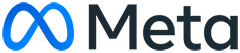

##**Prerequisites**
* Basic understanding of Large Language Models

* Basic understanding of Python

* Access to Github, GColab and Replicate

In [ ]:
# presentation layer code

import base64
from IPython.display import Image, display
import matplotlib.pyplot as plt

def mm(graph):
  graphbytes = graph.encode("ascii")
  base64_bytes = base64.b64encode(graphbytes)
  base64_string = base64_bytes.decode("ascii")
  display(Image(url="https://mermaid.ink/img/" + base64_string))

def genai_app_arch():
  mm("""
  flowchart TD
    A[Users] --> B(Applications e.g. mobile, web)
    B <--> |Hosted API|C(Platforms e.g. Custom, HuggingFace, Replicate, Together, Anyscale)
    B -- optional --> E(Frameworks e.g. LangChain or LlamaIndex)
    C-->|User Input|D[Llama 3]
    D-->|Model Output|C
    E --> C
    classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def rag_arch():
  mm("""
  flowchart TD
    A[User Prompts] --> B(Frameworks e.g. LangChain)
    B <--> |Database, Docs, XLS|C[fa:fa-database External Data]
    B -->|API|D[Llama 3]
    classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def llama3_family():
  mm("""
  graph LR;
      llama-3 --> llama-3-8b
      llama-3 --> llama-3-70b
      llama-3-8b --> llama-3-8b-base
      llama-3-8b --> llama-3-8b-instruct
      llama-3-70b --> llama-3-70b-base
      llama-3-70b --> llama-3-70b-instruct
      classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def apps_and_llms():
  mm("""
  graph LR;
    users --> apps
    apps --> frameworks
    frameworks --> platforms
    platforms --> Llama 2
    classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

import ipywidgets as widgets
from IPython.display import display, Markdown

# Create a text widget
API_KEY = widgets.Password(
    value='',
    placeholder='',
    description='API_KEY:',
    disabled=False
)

def md(t):
  display(Markdown(t))

def bot_arch():
  mm("""
  graph LR;
  user --> prompt
  prompt --> i_safety
  i_safety --> context
  context --> Llama_3
  Llama_3 --> output
  output --> o_safety
  i_safety --> memory
  o_safety --> memory
  memory --> context
  o_safety --> user
  classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def fine_tuned_arch():
  mm("""
  graph LR;
      Custom_Dataset --> Pre-trained_Llama
      Pre-trained_Llama --> Fine-tuned_Llama
      Fine-tuned_Llama --> RLHF
      RLHF --> |Loss:Cross-Entropy|Fine-tuned_Llama
      classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def load_data_faiss_arch():
  mm("""
  graph LR;
      documents --> textsplitter
      textsplitter --> embeddings
      embeddings --> vectorstore
      classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)

def mem_context():
  mm("""
      graph LR
      context(text)
      user_prompt --> context
      instruction --> context
      examples --> context
      memory --> context
      context --> tokenizer
      tokenizer --> embeddings
      embeddings --> LLM
      classDef default fill:#CCE6FF,stroke:#84BCF5,textColor:#1C2B33,fontFamily:trebuchet ms;
  """)


### **2.1 - Install dependencies**

In [ ]:
!pip install replicate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 kB 3.4 MB/s eta 0:00:00


### **2.2 - Create helpers for Llama 2 and Llama 3**

First, set your Replicate API token as environment variables.


In [ ]:
import os
from getpass import getpass

# REPLICATE_API_TOKEN = getpass()

os.environ["REPLICATE_API_TOKEN"] = "......"

# import os
# os.environ["REPLICATE_API_TOKEN"] = "......"  # put your token here

# import replicate

# output = replicate.run(
#     "meta/meta-llama-3-8b-instruct",
#     input={"prompt": "Hello from replicate"}
# )
# print(output)


Create Llama 2 and Llama 3 helper functions - for chatbot type of apps, we'll use Llama 3 8b/70b instruct models, not the base models.

In [ ]:
import replicate
# from replicate.client import Client

# replicate = Client(api_token="<.....>")
replicate = replicate.Client(api_token='....')

def llama3_8b(prompt, temperature=0.0):
  output = replicate.run(
    "meta/meta-llama-3-8b-instruct",
    input={
        "prompt": prompt,
        "max_tokens": 2048,
        "temperature": temperature})
  return "".join(output)



#### Load Data:

In [ ]:
import ast
import pandas as pd
import numpy as np

def clean_paraphrases(x):
    if isinstance(x, str):
        try:
            x = ast.literal_eval(x)
        except Exception:
            return [x]  # fallback: keep as single string

    # Sometimes it's a list of one big string that itself is a list
    while isinstance(x, list) and len(x) == 1 and isinstance(x[0], str):
        try:
            x = ast.literal_eval(x[0])
        except Exception:
            break

    # Finally, make sure it's a flat list of strings
    if isinstance(x, list) and all(isinstance(i, str) for i in x):
        return x
    return [str(x)]


# Convert string representation of lists to actual lists
# test['paraphrases'] = test['paraphrases'].apply(clean_paraphrases)
# test['aspect'] = test['aspect'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
#split  test['paraphrases']  based on \n :
# test['paraphrases'] = test['paraphrases'].apply(lambda x: x.split('\',\'') if isinstance(x, str) else x)
# test['paraphrases'] = test['paraphrases'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# ============= CASE : English dataset =============
# import ast  # to safely evaluate string lists

# # Convert string representation of lists to actual lists
# # test['category'] = test['category'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
# test['aspectTerms'] = test['aspectTerms'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# # Display the updated DataFrame to verify the changes
# print(type(test.iloc[1]['aspectTerms']))
# display(test.head())

def clean_list_values(x):
    """
    Clean a cell that may be a list or a single value.
    - If list: remove/skip NaN-like items.
    - If single: return [] if NaN-like, else wrap in a list.
    """
    # Case 1: list
    if isinstance(x, list):
        cleaned = []
        for v in x:
            if v is None or pd.isna(v) or str(v).strip().lower() == "nan":
                continue
            cleaned.append(str(v).strip())
        return cleaned

    # Case 2: scalar value
    if x is None or pd.isna(x) or str(x).strip().lower() == "nan":
        print('NaN value found')
        return []  # normalize to empty list
    return [str(x).strip()]  # wrap single value into list


def process_data(df):
    # Convert string representation of lists to actual lists
    # df['aspect'] = df['aspect'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
    df['paraphrases'] = df['paraphrases'].apply(clean_paraphrases)
    df["aspect"] = df["aspect"].apply(clean_list_values)

    #reset index for test:
    df.reset_index(drop=True, inplace=True)
    return df




In [ ]:
import pandas as pd

#Mount the drive:
from google.colab import drive
drive.mount('/content/drive')


# ============== 1. Load Test set ==========
#import test_df from the path
test= pd.read_csv("/content/drive/MyDrive/colab_files/Arabic_test.csv")
# test=pd.read_csv("test_15")
# test= test[test['dataset'] == 'se15']

# Process the data: (list-conversion and reset indexing)
# test = process_data(test)

test

Mounted at /content/drive


,sentence,paraphrases,index,dataset,domain,aspect,category,type,source_dataset,language
0,الغرف فسيحة ودورات المياة ممتازة وفخمة ومتكامل...,الغرف التي توجد في الفندق واسعة جداً، ودورات ا...,4659.0,SemEval2016,hotels,"['الغرف', 'دورات المياة', 'المسبح', 'واي فاي']","['ROOMS#DESIGN_FEATURES', 'ROOMS#QUALITY', 'FA...",explicit,SemEval2016,Arabic
1,بصراحة أنا ما أحب الكاتب اللي يدخل اللغة العام...,بصراحة، أنا لا أحب الشخص الكاتب الذي يستخدم ال...,0.0,HAAD,books,['اللغة العامية'],['اللغات'],explicit,HAAD,Arabic
2,روايه حزينه قد لاتستحق عناء القراءه,قصة حزينة تتميز بمحتوى قد لا يستحق بذل جهد الق...,1.0,HAAD,books,['روايه'],['الاسلوب'],explicit,HAAD,Arabic
3,والمشكله الوحيده التي واجهتني هي؛ القراءه بالل...,المشكلة الوحيدة التي قابلتني هي قراءة النص بال...,2.0,HAAD,books,['باللهجه المصريه'],['اللغات'],explicit,HAAD,Arabic
4,ربما يكون الكتاب جيداً ولكن بروز شخصية الكاتب ...,قد يكون الكتاب جيداً، ولكن ظهور شخصية الكاتب ا...,3.0,HAAD,books,['شخصية الكاتب'],['المشاعر'],explicit,HAAD,Arabic
...,...,...,...,...,...,...,...,...,...,...
1520,وفي اليوم التالي أيضًا، عانينا في سبيل الحصول ...,في اليوم الذي يليه كذلك، واجهنا صعوبات في الحص...,1519.0,SemEval2016,hotels,['المياه'],['FACILITIES#GENERAL'],explicit,SemEval2016,Arabic
1521,لم يتم استبدال المناشف في غرفتنا بالرغم من تنب...,لم يتم تبديل المناشف الموجودة في غرفتنا بالرغم...,1520.0,SemEval2016,hotels,['المناشف'],['ROOMS_AMENITIES#QUALITY'],explicit,SemEval2016,Arabic
1522,يعاني كل شخص من يوم سيء، وربما كان ذلك اليوم ه...,يعاني كل إنسان من يوم سلبي، وربما كان ذلك اليو...,1521.0,SemEval2016,hotels,"['الموقع', 'وجبة الإفطار']","['HOTEL#GENERAL', 'LOCATION#GENERAL', 'FOOD_DR...",explicit,SemEval2016,Arabic
1523,إقامة موفقة أقمت في هذا الفندق لمدة أربع ليال ...,أقمت في هذا الفندق لمدة أربع ليالٍ، وكانت إقام...,1522.0,SemEval2016,hotels,"['إقامة', 'الاستقبال', 'الخدمة', 'الإفطار']","['HOTEL#GENERAL', 'SERVICE#GENERAL', 'SERVICE#...",explicit,SemEval2016,Arabic


### **2.3 - Basic QA with Llama 2 and 3**

In [ ]:
# prompt = """Below is an instruction that describes a task, paired with an input Sentence that provides a text. Write a response that appropriately completes the request.
# ###Instruction:
# {}
# ###Sentence:
# {}
# ###Aspect:
# {}"""
prompt = """Below is an instruction that describes a task, paired with an input Sentence that provides a text. Write a response that appropriately completes the request.
###Instruction:
Act as a Natural Language Processing expert in Arabic Language.Your task is to extract Arabic aspect term(s) that are explicitly mentioned in the given sentence.
- Only return aspect terms that appear verbatim in the sentence.
- Do not infer or invent related words.
- If no aspect is found, return "none"
- Your response should only contain the extracted Arabic aspects after the keyword: " ###Aspect: "
###Sentence:
{}
###Aspect:
"""


# EOS_TOKEN = tokenizer.eos_token  # Must add EOS_TOKEN

def formatting_prompts_row(row):
    # return prompt + row["sentence"]
    return prompt.format(row["sentence"])

# train["text"] = train.apply(formatting_prompts_row, axis=1)
test["text"]  = test.apply(formatting_prompts_row, axis=1)
test

,sentence,paraphrases,index,dataset,domain,aspect,category,type,source_dataset,language,text
0,الغرف فسيحة ودورات المياة ممتازة وفخمة ومتكامل...,الغرف التي توجد في الفندق واسعة جداً، ودورات ا...,4659.0,SemEval2016,hotels,"['الغرف', 'دورات المياة', 'المسبح', 'واي فاي']","['ROOMS#DESIGN_FEATURES', 'ROOMS#QUALITY', 'FA...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,..."
1,بصراحة أنا ما أحب الكاتب اللي يدخل اللغة العام...,بصراحة، أنا لا أحب الشخص الكاتب الذي يستخدم ال...,0.0,HAAD,books,['اللغة العامية'],['اللغات'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,..."
2,روايه حزينه قد لاتستحق عناء القراءه,قصة حزينة تتميز بمحتوى قد لا يستحق بذل جهد الق...,1.0,HAAD,books,['روايه'],['الاسلوب'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,..."
3,والمشكله الوحيده التي واجهتني هي؛ القراءه بالل...,المشكلة الوحيدة التي قابلتني هي قراءة النص بال...,2.0,HAAD,books,['باللهجه المصريه'],['اللغات'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,..."
4,ربما يكون الكتاب جيداً ولكن بروز شخصية الكاتب ...,قد يكون الكتاب جيداً، ولكن ظهور شخصية الكاتب ا...,3.0,HAAD,books,['شخصية الكاتب'],['المشاعر'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,..."
...,...,...,...,...,...,...,...,...,...,...,...
1520,وفي اليوم التالي أيضًا، عانينا في سبيل الحصول ...,في اليوم الذي يليه كذلك، واجهنا صعوبات في الحص...,1519.0,SemEval2016,hotels,['المياه'],['FACILITIES#GENERAL'],explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,..."
1521,لم يتم استبدال المناشف في غرفتنا بالرغم من تنب...,لم يتم تبديل المناشف الموجودة في غرفتنا بالرغم...,1520.0,SemEval2016,hotels,['المناشف'],['ROOMS_AMENITIES#QUALITY'],explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,..."
1522,يعاني كل شخص من يوم سيء، وربما كان ذلك اليوم ه...,يعاني كل إنسان من يوم سلبي، وربما كان ذلك اليو...,1521.0,SemEval2016,hotels,"['الموقع', 'وجبة الإفطار']","['HOTEL#GENERAL', 'LOCATION#GENERAL', 'FOOD_DR...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,..."
1523,إقامة موفقة أقمت في هذا الفندق لمدة أربع ليال ...,أقمت في هذا الفندق لمدة أربع ليالٍ، وكانت إقام...,1522.0,SemEval2016,hotels,"['إقامة', 'الاستقبال', 'الخدمة', 'الإفطار']","['HOTEL#GENERAL', 'SERVICE#GENERAL', 'SERVICE#...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,..."


In [ ]:
import os
import time
import replicate
import pandas as pd
from tqdm import tqdm

# --- make sure the API token is set BEFORE importing replicate ---
# Replace with your real token, or ensure it's already set in your Colab environment
# os.environ["REPLICATE_API_TOKEN"] = os.environ.get("REPLICATE_API_TOKEN", "r8_Qh5Psa2EyBe99LTQzXzhCDuS4KS7B1a2Mtta5").strip()

replicate = replicate.Client(api_token='.....')
tqdm.pandas()

# --- safer wrapper with retries ---
def llama3_generate(prompt: str, retries: int = 3, delay: int = 5):
    for attempt in range(retries):
        try:
            output = replicate.run(
                "meta/meta-llama-3-8b-instruct",
                input={"prompt": prompt}
            )
            return "".join(output)
        except Exception as e:
            print(f"⚠️ Error: {e} | Attempt {attempt+1}/{retries}")
            time.sleep(delay)
    return "[ERROR]"

# --- ensure predictions column exists ---
if "prediction" not in test.columns:
    test["prediction"] = None

# --- loop row by row so we can save each response ---
for idx in tqdm(range(len(test))):
    if pd.isna(test.loc[idx, "prediction"]) or test.loc[idx, "prediction"] in [None, "", "[ERROR]"]:
        prompt = test.loc[idx, "text"]
        response = llama3_generate(prompt)
        test.loc[idx, "prediction"] = response

        # save after every response
        test.to_csv("test_with_predictions.csv", index=False, encoding="utf-8")


100%|██████████| 1525/1525 [20:03<00:00,  1.27it/s]


#### Post-process response:

In [ ]:
import re

def extract_aspect(response: str) -> str:
    if not isinstance(response, str):
        return ""

    # Regex: capture text after "###Aspect:" (case-insensitive) until newline
    match = re.search(r"###Aspect:\s*(.*)", response, flags=re.IGNORECASE)
    if match:
        aspect = match.group(1).strip()

        # if nothing after colon, maybe aspect is on the next line
        if aspect == "":
            lines = response.splitlines()
            for i, line in enumerate(lines):
                if line.strip().lower().startswith("###aspect:") and i + 1 < len(lines):
                    aspect = lines[i+1].strip()
                    break

        # normalize "none" (any case/format) to empty string
        if aspect.lower() == "none":
            return ""
        return aspect
    return ""
test["aspect_extracted"] = test["prediction"].apply(extract_aspect)


In [ ]:
import pandas as pd


# Keep Arabic letters AND commas
test['clean_aspect'] = test['aspect_extracted'].str.replace(r'[^ء-ي،,]', '', regex=True)

# If you want to keep both Arabic comma (،) and Western comma (,):
# df['clean_column'] = df['text_column'].str.replace(r'[^ء-ي،,]', '', regex=True)
# Or using Unicode ranges for more specificity:
# df['clean_column'] = df['text_column'].str.replace(r'[^\u0600-\u06FF]', '', regex=True)
test

,sentence,paraphrases,index,dataset,domain,aspect,category,type,source_dataset,language,text,prediction,aspect_extracted,clean_aspect
0,الغرف فسيحة ودورات المياة ممتازة وفخمة ومتكامل...,الغرف التي توجد في الفندق واسعة جداً، ودورات ا...,4659.0,SemEval2016,hotels,"['الغرف', 'دورات المياة', 'المسبح', 'واي فاي']","['ROOMS#DESIGN_FEATURES', 'ROOMS#QUALITY', 'FA...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: فسيحة\n\nNote: The aspect term ...,فسيحة,فسيحة
1,بصراحة أنا ما أحب الكاتب اللي يدخل اللغة العام...,بصراحة، أنا لا أحب الشخص الكاتب الذي يستخدم ال...,0.0,HAAD,books,['اللغة العامية'],['اللغات'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: أحب (Hubb) - past tense of the ...,"أحب (Hubb) - past tense of the verb ""to love"" ...",أحب
2,روايه حزينه قد لاتستحق عناء القراءه,قصة حزينة تتميز بمحتوى قد لا يستحق بذل جهد الق...,1.0,HAAD,books,['روايه'],['الاسلوب'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: حزينه (Hazīnah),حزينه (Hazīnah),حزينه
3,والمشكله الوحيده التي واجهتني هي؛ القراءه بالل...,المشكلة الوحيدة التي قابلتني هي قراءة النص بال...,2.0,HAAD,books,['باللهجه المصريه'],['اللغات'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,...","\n\n###Aspect: مسموعه, مقروءه\n\nThe two Arabi...","مسموعه, مقروءه","مسموعه,مقروءه"
4,ربما يكون الكتاب جيداً ولكن بروز شخصية الكاتب ...,قد يكون الكتاب جيداً، ولكن ظهور شخصية الكاتب ا...,3.0,HAAD,books,['شخصية الكاتب'],['المشاعر'],explicit,HAAD,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: متملقه (tamliqah),متملقه (tamliqah),متملقه
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1520,وفي اليوم التالي أيضًا، عانينا في سبيل الحصول ...,في اليوم الذي يليه كذلك، واجهنا صعوبات في الحص...,1519.0,SemEval2016,hotels,['المياه'],['FACILITIES#GENERAL'],explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: لم \n\nNote: The Arabic aspect ...,لم,لم
1521,لم يتم استبدال المناشف في غرفتنا بالرغم من تنب...,لم يتم تبديل المناشف الموجودة في غرفتنا بالرغم...,1520.0,SemEval2016,hotels,['المناشف'],['ROOMS_AMENITIES#QUALITY'],explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,...","\n\n###Aspect: تم\n\nThe aspect term ""تم"" is e...",تم,تم
1522,يعاني كل شخص من يوم سيء، وربما كان ذلك اليوم ه...,يعاني كل إنسان من يوم سلبي، وربما كان ذلك اليو...,1521.0,SemEval2016,hotels,"['الموقع', 'وجبة الإفطار']","['HOTEL#GENERAL', 'LOCATION#GENERAL', 'FOOD_DR...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: السيء (si'aa),السيء (si'aa),السيء
1523,إقامة موفقة أقمت في هذا الفندق لمدة أربع ليال ...,أقمت في هذا الفندق لمدة أربع ليالٍ، وكانت إقام...,1522.0,SemEval2016,hotels,"['إقامة', 'الاستقبال', 'الخدمة', 'الإفطار']","['HOTEL#GENERAL', 'SERVICE#GENERAL', 'SERVICE#...",explicit,SemEval2016,Arabic,"Below is an instruction that describes a task,...",\n\n###Aspect: لمدة,لمدة,لمدة


In [ ]:
#save test as csv file named (zero-shot_prediction.csv):
test.to_csv('zero-shot_prediction_Arabic.csv', encoding='utf-8-sig')
from google.colab import files
files.download('zero-shot_prediction_Arabic.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>